# Blog: Trying out the use of covariance matrices in Gaia DR2 distance estimations from parallax
*This blog is generated from a Jupyter Notebook found [here](https://github.com/ojhall94/hackshop/blob/master/blogs/covariances_blog.ipynb) *

Using a sample of quasars in *Gaia* DR2, [Lindegren et al. (2018)](http://adsabs.harvard.edu/abs/2018arXiv180409366L) find a positive covariance between parallax uncertainties, where they quantify the covariance as

$V_\varpi(\theta_{ij}) = <(\varpi_i - \overline{\varpi})(\varpi_j - \overline{\varpi})>$

where $\theta_{ij}$ is the angular separation between two parallaxes $i$ and $j$, and $\overline\varpi$ is the mean parallax of all the quasars in subsections of the sample $(0.057 \times 0.057 \rm deg^2$, in their case).

For angles $<40^\circ$ they find that the large-scale systematics are reasonably well approximated by the fitted exponential

$V_\varpi(\theta_{ij}) = (285\mu \rm{as}^2) \times exp(-\theta/14^\circ)$

We will try and recreate the work by [Bailer-Jones et al. (2018)](http://adsabs.harvard.edu/abs/2018AJ....156...58B) in order to find distances given the parallaxes and a reasonable prior as given by Bailer-Jones (2015), first without and then with taking covariances between parallax uncertainties into account. This is the same methodology as used in as [Zinn et al. (2018)](http://adsabs.harvard.edu/abs/2018arXiv180502650Z), [Khan et al. (2018)](https://ui.adsabs.harvard.edu/abs/2019arXiv190405676K/abstract) and [Hall et al. (2019)](https://arxiv.org/abs/1904.07919).

**Important Note:** Do not confuse this with the covariance between the products of the astrometric solution, i.e. ra, dec, proper motions and parallax. I am here interested in the local covariance of uncertainties in parallax *alone*.

The model we'll be using is a Bayesian model in PyStan: we use the parallaxes and parallax uncertainties, along with a exponentially decaying space distance prior (Bailer-Jones et al. 2018) to estimate the 'true parallax', i.e. one over the distance in parsec.

An acyclic diagram for this can be seen below, where $\hat\varpi$ is the parallax, $\sigma_{\hat\varpi}$ is the uncertainties, $r_i$ is the inferred distance and $L_i$ is the value for the length scale of the distance prior given in the Bailer-Jones et al. 2018 work.

![Acyclic diagram for our model](blogmodel.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_palette('colorblind')
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
matplotlib.rcParams['text.usetex'] = False
from astropy.table import Table
import warnings
warnings.filterwarnings('ignore')

Lets first read in the Kepler data set. Lets take the first 500 stars or so. You can download this file [here](https://gaia-kepler.fun/). Thanks Megan Bedell!

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


Targets in our dataframe: 500


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


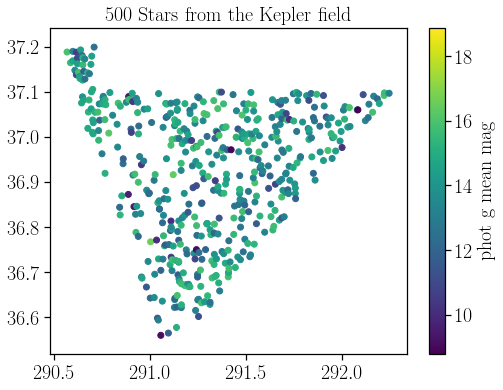

In [22]:
#And then lets take the first 200 of those at random
data = Table.read('kepler_dr2_1arcsec.fits', format='fits')
df = data.to_pandas()[:500]

print('Targets in our dataframe: '+str(len(df)))
f,a = plt.subplots(figsize=(8,6))
c = a.scatter(df.ra, df.dec, c=df.phot_g_mean_mag, cmap='viridis')
f.colorbar(c, label=r"phot g mean mag")
a.set_title('{} Stars from the Kepler field'.format(len(df)),fontsize=20)
plt.show()

## First, lets do this not taking into account any covariances

Please note that I include the (hotly debated) parallax zero-point offset as used in the Bailer-Jones  et al. 2018 work, which I'm aiming to recreate here. This means I will be using the Lindegren et al. 2019 global average value of 0.029 mas, which is *incorrect* for the *Kepler* field.

In [6]:
import pystan
overwrite=False
nocov = '''
functions {
    real bailerjones_lpdf(real r, real L){             //This is our distance prior
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;   // Number of data points
    vector[N] oo;       // Parallax values in mas
    vector[N] oo_err;   // Parallax error in mas
    real L[N];          // Length scale of distance prior from models
}
parameters {
    vector<lower = 1.>[N] ri;   // Distance in parsec
}
model {
    vector[N] oo_true;

    for (n in 1:N){
        ri[n] ~ bailerjones(L[n]);          // r is drawn from the distance prior
        oo_true[n] = (1000./ri[n] - 0.029); // the true parallax is drawn from the distance
    }

    oo ~ normal(oo_true, oo_err);           // likelihood of the true parallax to agree with observations
}
'''
import os
import pickle
model_path = 'nocov.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = nocov)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = nocov)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [7]:
dat = {'N': len(df),
        'oo' : df.parallax.values,           #Observed parallax
        'oo_err' : df.parallax_error.values, #Observed parallax error
        'L': df.r_length_prior.values}       #Length Scale

start = time.time()
fit = sm.sampling(data=dat, iter=1000, chains=2)
end = time.time()
print('Time taken to run was: {:.2f} seconds'.format(end-start))

Time taken to run was: 13.59 seconds


Now lets have a quick look at what the inferred distances look like, and how they compare to those presented in Bailer-Jones et al. 2018.

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


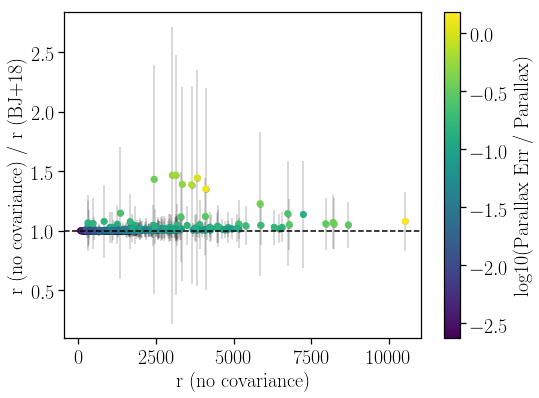

In [8]:
rinfd_nocov = np.median(fit['ri'], axis=0)
std = np.std(fit['ri'],axis=0)

fig, ax = plt.subplots(figsize=(8,6))
c = ax.scatter(rinfd_nocov, rinfd_nocov/df.r_est.values, c=np.log10(np.abs(1./df.parallax_over_error)), cmap='viridis', zorder=2)
ax.errorbar(rinfd_nocov, rinfd_nocov/df.r_est.values, yerr = std/df.r_est.values, 
            alpha=.2, fmt='o', zorder=1,c='k')
ax.axhline(1., linestyle='--', c='k')

fig.colorbar(c, label='log10(Parallax Err / Parallax)')
ax.set_xlabel('r (no covariance)')
ax.set_ylabel('r (no covariance) / r (BJ+18)')
plt.show()

Not bad! Theres some scatter and it tails off for large fractional uncertainties, but thats expected given this quick and easy approach--- I'm also estimating our distances as the median of the distribution, *unlike* Bailer-Jones et al., who take the **mode of the distribution**. But we've got something that looks reasonable, at least!

## Now lets do the same again, but accounting for covariance!

The parallax uncertainties can covary as a function of angular separation, as quantified in Lindegren et al. 2018 to be:

$V_\varpi(\theta_{ij}) = (285\mu \rm{as}^2) \times exp(-\theta/14^\circ)$

Using this we can build up a covariance matrix for our targets as:

$\Sigma_{ij}(\theta_{ij}) = (285\times10^{-6} m\rm{as}^2) \times exp(-\theta_{ij}/14^\circ) + \delta_{ij}\sigma^2_{\hat{\varpi}_i}$

where $\delta_{ij}$ is the Kronecker delta function as we populate the diagonal of our matrix with the regular variance. Note that this formulation of the matrix makes it so that the variances are inflated also by a fixed offset of $285\mu\rm as^2 \approx 17\mu\rm as$, the uncertainty associated with the spatial correlation.

*Note: This value might actually be an underestimate for targets fainter than 13 G. For more, see Khan et al. (2018) and [Slide 35 of this talk](https://www.cosmos.esa.int/web/gaia/dr2-known-issues).



First off lets calculate the angular separation in degrees.

In [9]:
def kernel(ra, dec, sigma, p):
    '''
    p[0] : Offset
    p[1] : Exponential decay scale
    '''
    dr = np.deg2rad(dec)
    thetaij = np.sqrt((np.subtract.outer(ra, ra)*np.cos(0.5*np.add.outer(dr, dr)))**2 + np.subtract.outer(dec, dec)**2)
    cov = p[0] * np.exp(-thetaij / p[1])
    np.fill_diagonal(cov, np.diag(cov) + sigma**2)
    return cov

In [10]:
p = [285.0*10**-6, 14.]
Sigmaij = kernel(df.ra.values, df.dec.values, df.parallax_error.values, p)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


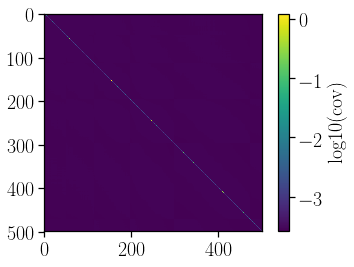

In [11]:
c = plt.imshow(np.log10(Sigmaij))
plt.colorbar(c, label='log10(cov)')
plt.show()
if not np.all(np.linalg.eigvals(Sigmaij) > 0):
    raise ValueError("The matrix isn't positive-definite for some reason!")

### Alright, we have a covariance matrix!

Time to include it in our model! A multivariate normal distribution, given a matrix of covariances, reads as

$p(\hat\varpi | \varpi_{true}, \sigma_{\hat\varpi}) = \frac{1}{\sqrt{(2\pi)^N |\Sigma|}} \times \exp\left[-\frac{1}{2}(\underline{\varpi_{true}} - \underline{\hat\varpi})^{\rm T} \Sigma^{-1} (\underline{\varpi_{true}} - \underline{\hat\varpi})\right]$

where $\Sigma$ is our covariance matrix, $N$ is the number of data points, and $\varpi_{true}$ is the inferred true parallax, i.e. one over the inferred distance ($1/\underline{r}$)! The underline indicates that its a vector containing all instances $i$ of the parallax.

An acyclic diagram for this new model can be seen below. The only change is that instead of $\sigma_{\hat{\varpi}_i}$ we now feed in the covariance matrix $\Sigma_{\hat{\varpi}}$ and evaluate all the parallaxes in the vector $\underline{\hat{\varpi}}$!

![Acyclic diagram for our model](blogmodel2.png)

Lets recreate the model but now taking into account the covariance matrix.

In [12]:
import pystan
overwrite=False
yescov = '''
functions {
    real bailerjones_lpdf(real r, real L){             //This is our distance prior
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;    // Number of data points
    vector[N] oo;        // Parallax values in mas
    real L[N];           // Length scale of distance prior from models
    cov_matrix[N] Sigma; // The full covariance matrix
}
parameters {
    vector<lower = 1.>[N] ri;       // Distance in parsec
}
model {
    vector[N] oo_true;

    for (n in 1:N){
        ri[n] ~ bailerjones(L[n]);          // r is drawn from the distance prior
        oo_true[n] = (1000./ri[n] - 0.029); // the true parallax is drawn from the distance
    }
    
    oo ~ multi_normal(oo_true, Sigma);      //This has changed to a multi_normal now!
}
'''
import os
import pickle
model_path = 'yescov.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = yescov)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = yescov)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [13]:
dat = {'N': len(df),
        'oo' : df.parallax.values,       #Observed parallax
        'Sigma': Sigmaij,                #The covariance matrix
        'L': df.r_length_prior.values}   #Length Scale

start = time.time()
cov_fit = sm.sampling(data=dat, iter=1000, chains=2)
end = time.time()
print('Time taken to run was: {:.2f} minutes'.format((end-start)/60))

Time taken to run was: 10.84 minutes


Lets see how our distances have changed compared to our estimate without the covariance.

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


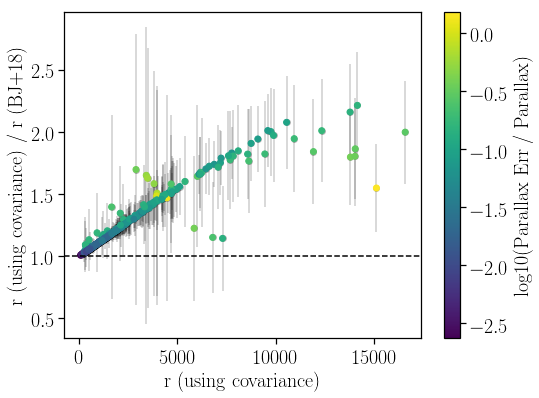

In [14]:
rinfd_cov = np.median(cov_fit['ri'], axis=0)
std = np.std(cov_fit['ri'],axis=0)

fig, ax = plt.subplots(figsize=(8,6))
c = ax.scatter(rinfd_cov, rinfd_cov/df.r_est.values, c=np.log10(np.abs(1./df.parallax_over_error)), cmap='viridis', zorder=2)
ax.errorbar(rinfd_cov, rinfd_cov/df.r_est.values, yerr = std/df.r_est.values, 
            alpha=.2, fmt='o', zorder=1,c='k')
ax.axhline(1., linestyle='--', c='k')

fig.colorbar(c, label='log10(Parallax Err / Parallax)')
ax.set_xlabel('r (using covariance)')
ax.set_ylabel('r (using covariance) / r (BJ+18)')
plt.show()

So this shows that by including the covariance, we find that at large distances we have previously underestimated the distance to objects with the smallest parallaxes. 

This effect is due to the $1/r$ relation to parallax. When increasing parallax uncertainty, we make larger values of distance more likely, shifting the median of the probability distribution to larger distances. **Please don't take these as proper measures of distance, I'm just trying to show how to work a covariance matrix into your stan model.**

As an aside, we can see the Bailer-Jones prior at work here--- the stars closest to the bisector at large distances are those with large parallax uncertainties. For these stars the prior dominates, and thus we achieve similar results, as the effect of the covariance matters little compared to the effect of the prior.

## This slow things down quite a lot, we've gone from orders of seconds to orders of minutes.

## ...lets speed it up!

The thing that really hogs the CPU in these processes is calculating the inversion and determinant of our covariance matrix at every step in the MCMC chain. This is superfluous: we're not changing the covariance matrix at all!

Using the Pystan multi_normal function scales with the size of the covariance matrix as $O(N^3)$.

If we *really* want to speed up our model so we can treat many parallaxes simultaneously, we want to write our own multivariate normal distribution function in Pystan in log space, and pass in a **pre-calculated** determinant and covariance matrix inverse.

In [19]:
import pystan
overwrite=False
fastcov = '''
functions {
    real bailerjones_lpdf(real r, real L){             //This is our distance prior
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
    real precalc_multinormal_lpdf(vector oo, vector oo_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;       
        r = oo - oo_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }
}
data {
    int<lower = 0> N;
    real<lower=0> Nfloat;
    vector[N] oo;
    real L[N];
    
    real logdetc;       // The log determinant
    matrix[N, N] invc;  // The inverted matrix (not positive-definite, so not a cov_matrix)
}
parameters {
    real<lower = 1.> ri[N];     // Distance in parsec
}
model {
    vector[N] oo_true;

    for (n in 1:N){
        ri[n] ~ bailerjones(L[n]);
        oo_true[n] = (1000./ri[n] - 0.029);            //We're accounting for a parallax offset of 0.029 mu-as
    }
    
    // Our likelihood function is now a custom function we've written above
    oo ~ precalc_multinormal(oo_true, logdetc, invc, N, Nfloat);      
}
'''
import os
import pickle
model_path = 'fastcov.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = ultcov)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = ultcov)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d9a0a48349e3a238123aa15659f553de NOW.


Saving Stan Model


In [18]:
invc = np.linalg.inv(Sigmaij)            # Calculate the inverse
logdetc = np.linalg.slogdet(Sigmaij)[1]  # Calculate the log determinant

In [20]:
dat = { 'N': len(df),
        'Nfloat': np.float(len(df)),
        'oo' : df.parallax.values,       #Observed parallax
        'L': df.r_length_prior.values,
        'logdetc' : logdetc,
        'invc' : invc} 


start = time.time()
fastcov_fit = sm.sampling(data=dat, iter=1000, chains=2)
end = time.time()
print('Time taken to run was: {:.2f} minutes'.format((end-start)/60))

Time taken to run was: 5.79 minutes


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


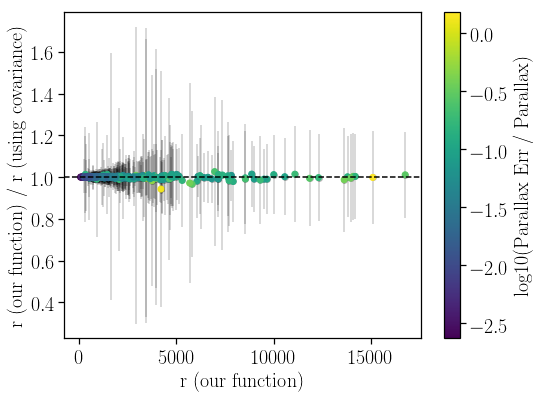

In [21]:
rinfd_fastcov = np.median(fastcov_fit['ri'], axis=0)
std = np.std(fastcov_fit['ri'],axis=0)

fig, ax = plt.subplots(figsize=(8,6))
c = ax.scatter(rinfd_fastcov, rinfd_fastcov/rinfd_cov, c=np.log10(np.abs(1./df.parallax_over_error)), cmap='viridis', zorder=2)
ax.errorbar(rinfd_fastcov, rinfd_fastcov/rinfd_cov, yerr = std/rinfd_cov, 
            alpha=.2, fmt='o', zorder=1,c='k')
ax.axhline(1., linestyle='--', c='k')

fig.colorbar(c, label='log10(Parallax Err / Parallax)')
ax.set_xlabel('r (our function)')
ax.set_ylabel('r (our function) / r (using covariance)')
plt.show()

Again, our results agree with a run using no fancy was to increase speed, so we know we've done a good job.

So lets break down the speeds of these four processes:

 - Normal (no covariance): 14 s
 - Multi_Normal (using covariance): 10.84 min
 - Precalc_Multinormal (precalculated covariance matrix inversion & determinant): 5.79 min

Since we're still working with matrices at the end of the day, this won't scale linearly, unfortunately. For this example, once you start going over ~1500 stars, things really start to slow down. But thats a lot more than you'd be able to reasonably do with the basic multi_normal function!

## Hope this helped!

Hope somebody found this helpful! Check out [our paper](https://arxiv.org/abs/1904.07919), where we apply this technique to 1000 *Kepler* stars.

You can contact me on [Twitter](https://www.twitter.com/asteronomer), by [email](mailto:ojh251@student.bham.ac.uk) or on my [Github](https://www.github.com/ojhall94)!

# Some additional code

The code to generate the probabilistic graphical models using daft for the two models

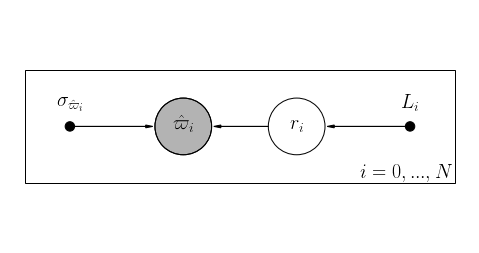

In [3]:
import daft
import warnings
warnings.filterwarnings('ignore')
pgm = daft.PGM(shape=[4., 2.],origin=[0, 0], grid_unit=4,label_params={'fontsize':20},observed_style='shaded')
pgm.add_node(daft.Node("ooi", r"$\hat{\varpi}_i$", 1.5, 1, scale=2, observed=True))
pgm.add_node(daft.Node("ri", r"$r_i$", 2.5, 1, scale=2))
pgm.add_node(daft.Node("Li", r"$L_i$", 3.5, 1, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_node(daft.Node("sigooi", r"$\sigma_{\hat{\varpi}_i}$", 0.5, 1, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_plate(daft.Plate([0.1, 0.5, 3.8, 1.0], r"$i=0,...,N$",position='bottom right', rect_params={'fill':False}))
# draw directed edges
pgm.add_edge("ri", "ooi")
pgm.add_edge("Li", "ri")
pgm.add_edge('sigooi', 'ooi')

pgm.render()
pgm.figure.savefig('blogmodel.png')

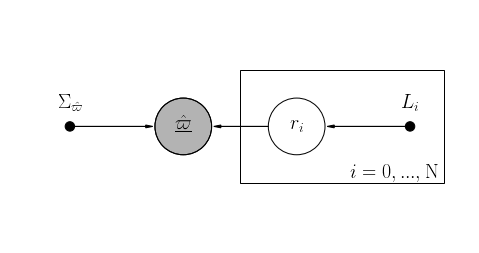

In [4]:
import daft
pgm = daft.PGM(shape=[4., 2.],origin=[0, 0], grid_unit=4,label_params={'fontsize':20},observed_style='shaded')
pgm.add_node(daft.Node("ooi", r"$\underline{\hat{\varpi}}$", 1.5, 1, scale=2, observed=True))
pgm.add_node(daft.Node("ri", r"$r_i$", 2.5, 1, scale=2))
pgm.add_node(daft.Node("Li", r"$L_i$", 3.5, 1, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_node(daft.Node("sigooi", r"$\Sigma_{\hat{\varpi}}$", 0.5, 1, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_plate(daft.Plate([2.0, 0.5, 1.8, 1.0], r"$i=0,...,\rm N$",position='bottom right', rect_params={'fill':False}))
# draw directed edges
pgm.add_edge("ri", "ooi")
pgm.add_edge("Li", "ri")
pgm.add_edge('sigooi', 'ooi')

pgm.render()
pgm.figure.savefig('blogmodel2.png')